# CS4055 - Data Mining and Warehousing - Project 17/18

Lecturer: Nik Nikolov

14161044 - Oliver Gavin

14117495 - Jonathan Lloyd

13148583 - Jay Conroy

# Table of Contents

1. [Introduction](#intro)
2. [Initial Setup](#setup)
3. [Dataset Description](#dataset)
4. [Dataset Preparation](#prep)
5. [Predictive Analysis](#predict)<br>
    5.1 [KNN](#knn)<br>
    5.2 [Naive Bayes](#naive)<br>
    5.3 [Logistic Regression](#logreg)<br>
    5.4 [Support Vector Machines](#svm)<br>
    5.5 [Decision Trees](#trees)<br>
6. [Descriptive Analytics](#desc)<br>
    6.1 [K-Means](#kmeans)<br>
    6.2 [Spectral Clustering](#spect)<br>
7. [Conclusion](#conclusion)

<a id="intro"></a>
## Introduction

For this project, we used the Jupyter Notebook for building our report. Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Jupyter allowed us to leverage many helpful Python-based libraries for data mining, such as pandas, NumPy, scikit-learn, seaborn and matplotlib.
* NumPy: adds support for large, multi-dimensional arrays and matrices, along with a library of mathematical functions to operate on these arrays
* pandas: offers data structures and operations for manipulating numerical tables and time series
* sckit-learn: includes simple and efficient tools for data mining and data analysis. It features various classification, regression and clustering algorithms.
* matplotlib: is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats
* seaborn: provides a high-level interface for drawing attractive statistical graphics, based on matplotlib

Below are some examples of initial importing and setup of the Python libraries we used for the project. Additional libraries are imported throughout this notebook, when needed.

<a id="setup"></a>
## Initial Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)

from matplotlib.colors import LinearSegmentedColormap
binary_cmap = LinearSegmentedColormap.from_list('binarycmap', [(0.12156862745098039, 0.46666666666666667, 0.70588235294117652),
 (1.0, 0.49803921568627452, 0.054901960784313725)])

The following are utility functions we wrote to assist with plotting data:

In [2]:
import itertools

def plot_confusion_matrix(cm,
                          classes=['Benign', 'Malignant'],
                          normalize=False,
                          title='Confusion matrix',
                          ax=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if ax:
        plt.axes(ax)
    else:
        plt.figure(figsize=(3,3))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    
    Source: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    
    Source: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_classifier(clf, ax, X0, X1, y, title, xlabel, ylabel):
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=binary_cmap, alpha=0.3)
    ax.scatter(X0, X1, c=y, s=20, cmap=binary_cmap, alpha=0.7)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


<a id="dataset"></a>
## 3. Dataset Description

Source: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

The attributes in this dataset have been computed from a digitised image of a fine needle apsirate (FNA) of a breast mass. The attributes describe the characteristics of the cell nuclei present in the image. FNA is a diagnostic procedure used to investigate lumps or masses. During FNA procedures, a thin, hollow needle is inserted into the sample mass and after being stained, the mass is examined under the microscope. Here is an example of a microscopic image after performing the FNA procedure (arrows indicate malignant cells):

<br>
![FNA_Image](breast-cancer/FNAC-breast-lump-with-MGG-staining.png "FNA Breast Lump")
<br>

Attribute Information:

    1) ID number
    2) Diagnosis (M = malignant, B = benign)
    3-32) Ten real-valued features are computed for each cell nucleus:

        a) radius (mean of distances from center to points on the perimeter)
        b) texture (standard deviation of gray-scale values)
        c) perimeter
        d) area
        e) smoothness (local variation in radius lengths)
        f) compactness (perimeter^2 / area - 1.0)
        g) concavity (severity of concave portions of the contour)
        h) concave points (number of concave portions of the contour)
        i) symmetry
        j) fractal dimension ("coastline approximation" - 1)
        
The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, attribute 3 is Mean Radius, attribute
13 is Radius SE, attribute 23 is Worst Radius.

In [3]:
raw_data = pd.read_csv('breast-cancer/data.csv')


## Example raw data

Panda's 'head' function outputs the top 10 rows in the dataset below:

In [4]:
raw_data.head(10)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   
5    843786         M        12.45         15.70           82.57      477.1   
6    844359         M        18.25         19.98          119.60     1040.0   
7  84458202         M        13.71         20.83           90.20      577.9   
8    844981         M        13.00         21.82           87.50      519.8   
9  84501001         M        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010              0.14710   
1          0.08474           0.07864         0.08690              0.07017   
2          0.10960           0.15990         0.19740              0.12790   
3          0.14250           0.28390         0.24140              0.10520   
4          0.10030           0.13280         0.19800              0.10430   
5          0.12780           0.17000         0.15780              0.08089   
6          0.09463           0.10900         0.11270              0.07400   
7          0.11890           0.16450         0.09366              0.05985   
8          0.12730           0.19320         0.18590              0.09353   
9          0.11860           0.23960         0.22730              0.08543   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   
5         0.2087                 0.07613     0.3345      0.8902         2.217   
6         0.1794                 0.05742     0.4467      0.7732         3.180   
7         0.2196                 0.07451     0.5835      1.3770         3.856   
8         0.2350                 0.07389     0.3063      1.0020         2.406   
9         0.2030                 0.08243     0.2976      1.5990         2.039   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   
5    27.19       0.007510         0.03345       0.03672            0.01137   
6    53.91       0.004314         0.01382       0.02254            0.01039   
7    50.96       0.008805         0.03029       0.02488            0.01448   
8    24.32       0.005731         0.03502       0.03553            0.01226   
9    23.94       0.007149         0.07217       0.07743            0.01432   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   
5      0.02165              0.005082         15.47          23.75   
6      0.01369              0.002179         22.88       

<a id="prep"></a>
## 4. Dataset Preperation

We used number of functions from the panda library are used for dataset preparation, such as 'drop', 'map' and 'value_counts'.

### Cleaning the data
The data shown above suffers from a slight problem; a column 'Unamed: 32' is introduced because the source data contains a trailing delimiter. This can be firstly removed, along with the 'id' column.

In [5]:
clean_data = raw_data.drop(['id', 'Unnamed: 32'], axis=1)

### Discretizing numeric attributes
The diagnosis is binary, either malignant or benign, so this attribute can be converted to numeric values

In [6]:
BENIGN = 0
MALIGNANT = 1
clean_data['diagnosis'] = clean_data['diagnosis'].map({'B':BENIGN,'M':MALIGNANT})

### Preliminary Insights & Visualisations
#### Class Distribution

In [7]:
class_distribution = clean_data['diagnosis'].value_counts()

print('Benign: ', class_distribution[BENIGN])
print('Malignant: ', class_distribution[MALIGNANT])

Benign:  357
Malignant:  212


#### Distribution and Pairwise Relationships
The matrix below gives us two key insights useful for selecting possibly good attributes. It models only the 'mean' values in the dataset, but similar observations can be seen for 'worst' values. However 'se' (standard error) values show less interesting results.

The diagonal shows the distribution of a single attribute for both classes.

The other plots show scatter plots for each pair of attributes. There is a clear correlation between area, perimeter and radius.

This visualisation can help for initial ideas on how this dataset may be classified.

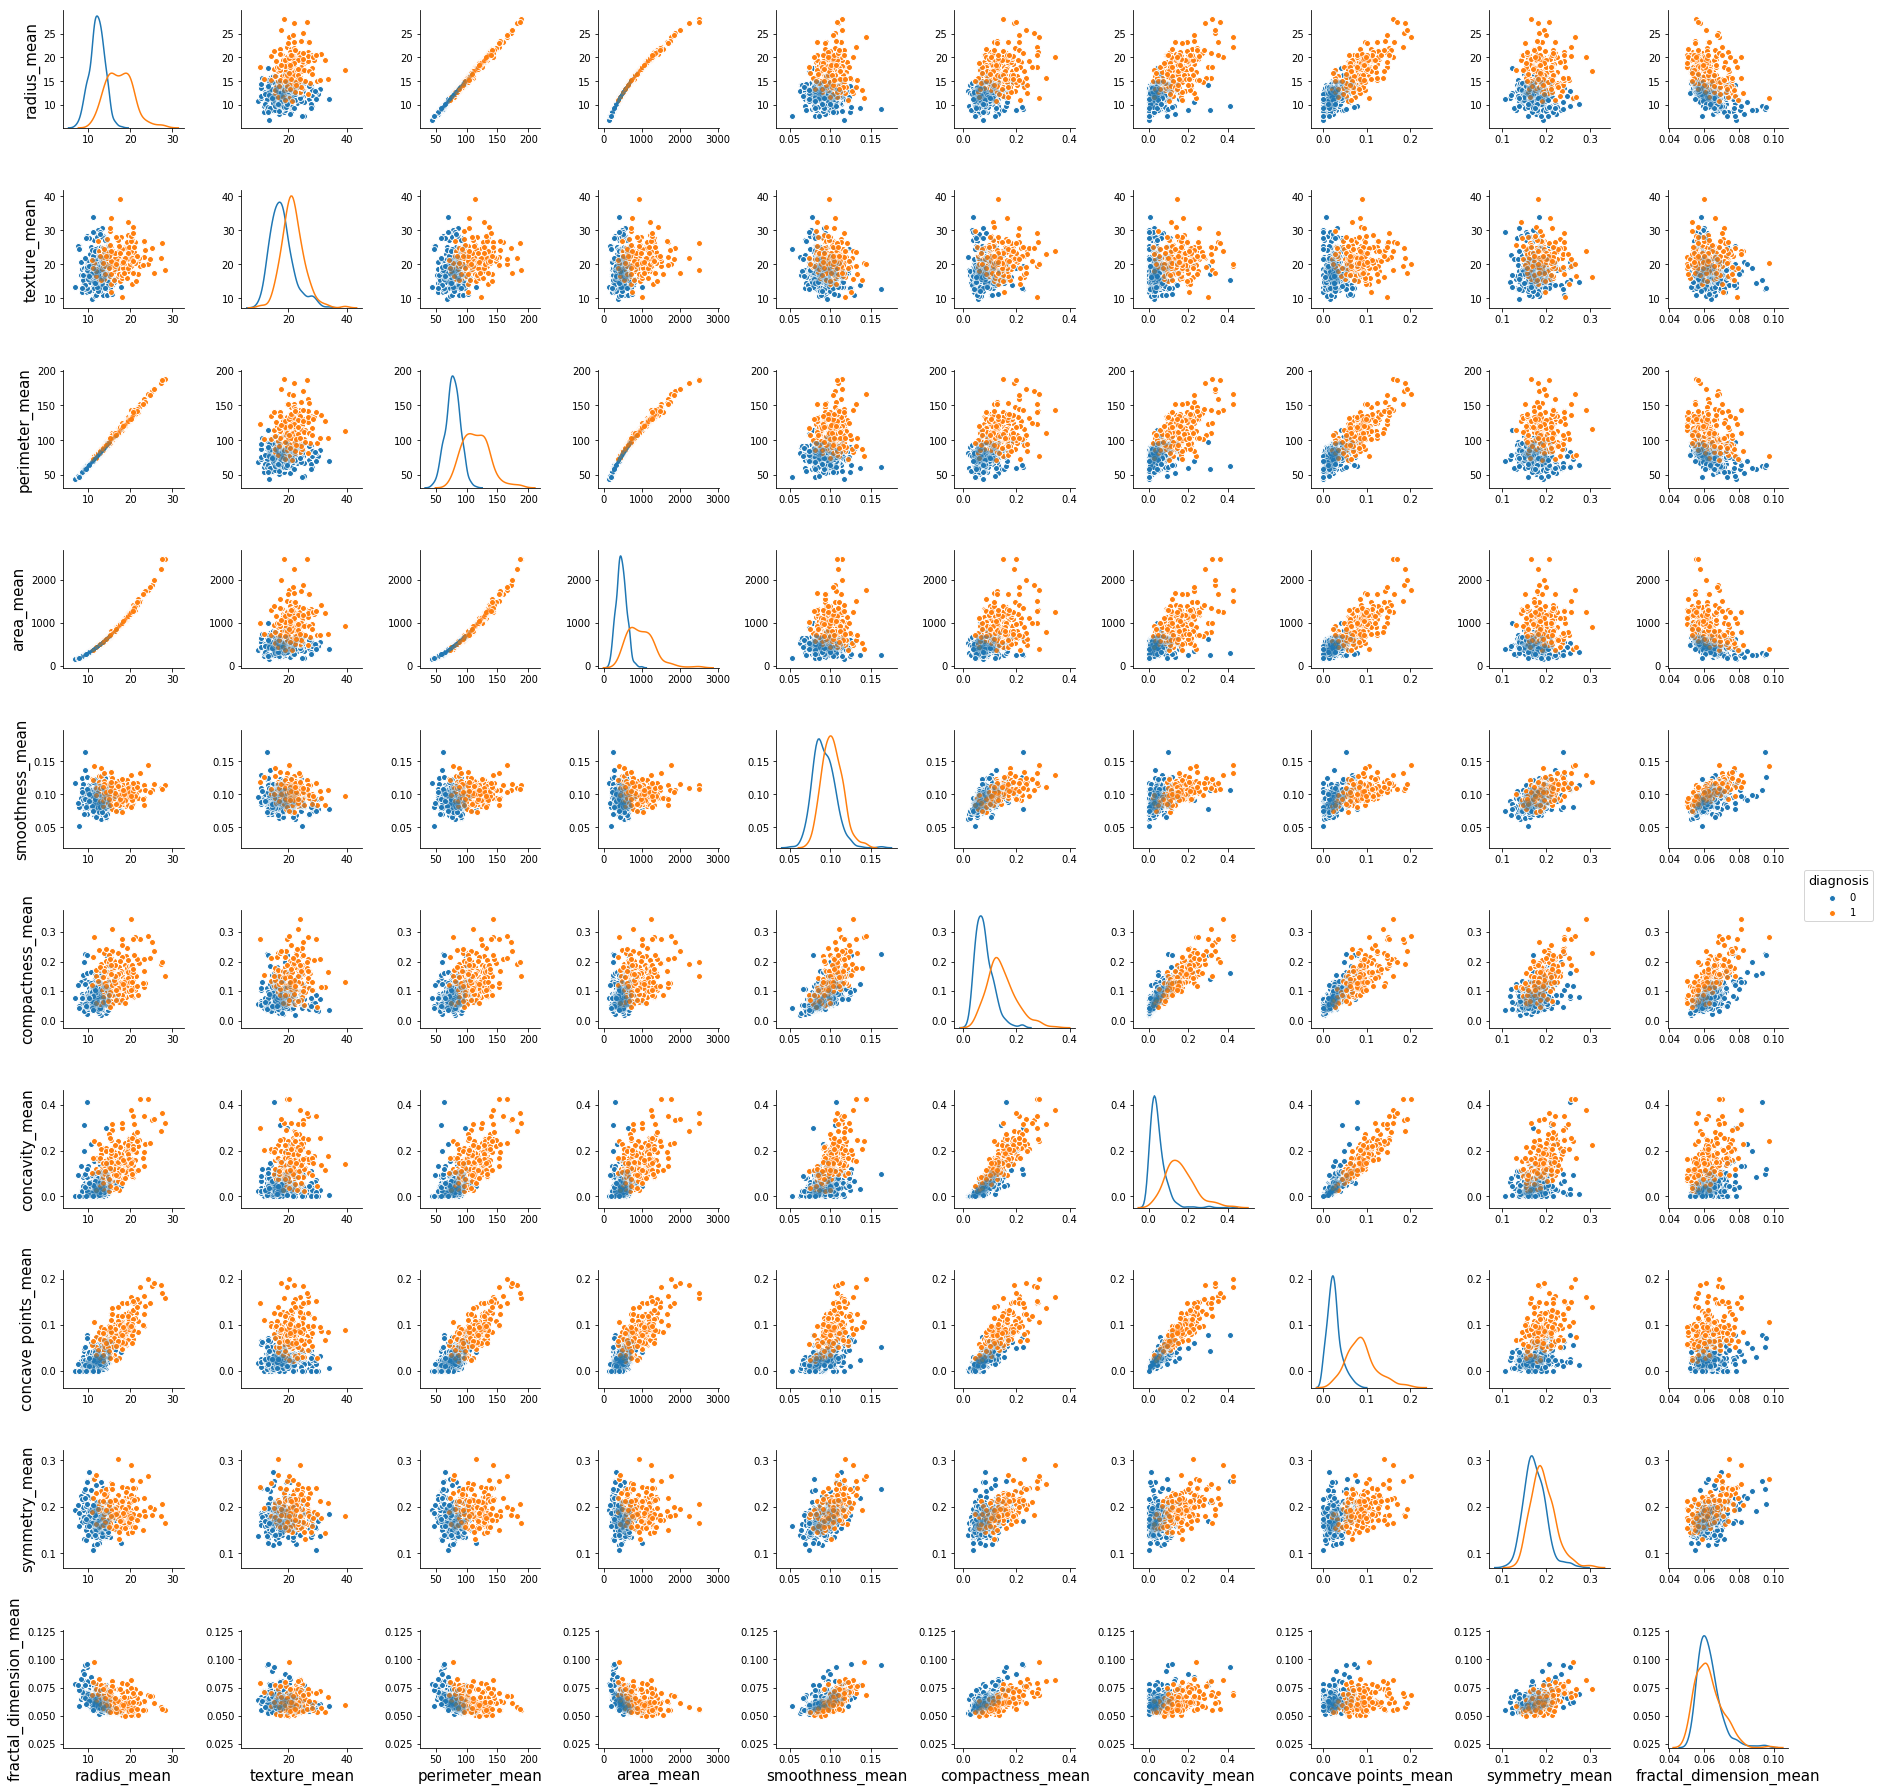

In [8]:
mean_labels = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
se_labels = ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']
worst_labels = ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

plt.rcParams["axes.labelsize"] = 15

g = sns.pairplot(clean_data, vars=mean_labels, hue='diagnosis', diag_kind="kde")
g = g.map_offdiag(plt.scatter, s=5, alpha=0.1)

In [9]:
data = clean_data.copy()

### Splitting into testing and training data

The data is split into 70% training and 30% testing using the 'train_test_split' module from sklearn.model_selection.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[mean_labels], data['diagnosis'],
                                                    test_size=0.3, shuffle=True, random_state=42)

### Manual Feature Selection
The 'mean' attributes seem appropriate for initial explorations.

Interesting single attributes based on distribution (suitable for OneR, logistic regression):

    1) concave points_mean
    2) concavity_mean
    3) radius_mean
    4) perimeter_mean
    5) compactness_mean
    
Other interesting combinations of attributes may be used for better insights (SVN, naive bayes, k-nearest neighbours, k-means).

Since we are using an automated approach, there is little need to select any features, however it is useful to note the ones we expect to be valuable.

### Automated Feature Selection
These methods produce similar results to manual selection

#### Recursive Feature Elimination selecting the best 5 attributes

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 5)
rfe = rfe.fit(X_train, y_train)
sorted(list(zip(mean_labels, rfe.ranking_)), key=lambda x: x[1])

[('radius_mean', 1),
 ('perimeter_mean', 1),
 ('concavity_mean', 1),
 ('concave points_mean', 1),
 ('symmetry_mean', 1),
 ('fractal_dimension_mean', 2),
 ('smoothness_mean', 3),
 ('compactness_mean', 4),
 ('texture_mean', 5),
 ('area_mean', 6)]

#### Extra Trees Classifier showing relative importance of each attribute using entropy

In [12]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(criterion='entropy')
model.fit(X_train, y_train)
sorted(list(zip(mean_labels, model.feature_importances_)), key=lambda x: x[1], reverse=True)

[('concavity_mean', 0.23607978174092689),
 ('area_mean', 0.15234528256704255),
 ('concave points_mean', 0.15193670504201168),
 ('radius_mean', 0.12883071125281081),
 ('perimeter_mean', 0.084947699130174401),
 ('compactness_mean', 0.078570616069812776),
 ('texture_mean', 0.05591529653718421),
 ('smoothness_mean', 0.047775078975913508),
 ('fractal_dimension_mean', 0.034955931056837433),
 ('symmetry_mean', 0.028642897627285752)]

##### Key Features

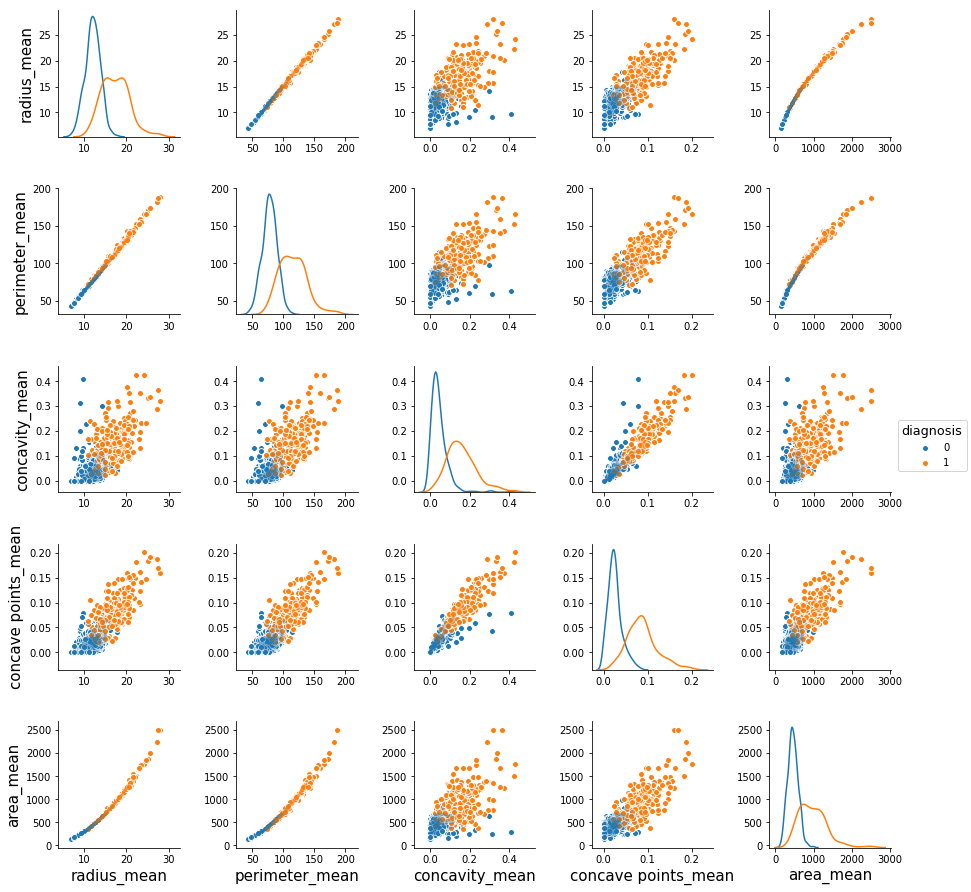

In [13]:
g = sns.pairplot(clean_data, vars=['radius_mean', 'perimeter_mean', 'concavity_mean', 'concave points_mean', 'area_mean'], hue='diagnosis', diag_kind="kde")
g = g.map_offdiag(plt.scatter, s=5, alpha=0.1)

Ignoring the highly correlated features, radius_mean and concavity_mean, for example, may be good features.

In [14]:
features = ['radius_mean', 'concavity_mean']

### Standardisation
Many algorithms require the data to be somewhat normalised or standardised to perform accurately and avoid skewed results.

We standardize features by removing the mean and scaling to unit variance.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

standardized_X_train = X_train.copy()
standardized_X_train[standardized_X_train.columns] = scaler.fit_transform(standardized_X_train[standardized_X_train.columns])

standardized_X_test = X_test.copy()
standardized_X_test[standardized_X_test.columns] = scaler.fit_transform(standardized_X_test[standardized_X_test.columns])


In [16]:
standardized_X_train.head(5)

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
149    -0.123490     -0.296801       -0.170507  -0.208616        -1.201680   
124    -0.228268     -0.657951       -0.253775  -0.296503        -1.804637   
421     0.145534     -1.230564        0.245833  -0.010242         0.519184   
195    -0.358532     -0.672207       -0.400937  -0.400014        -1.203862   
545    -0.157472      0.967224       -0.208843  -0.241538        -0.254695   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
149         -0.773170       -0.762312            -0.933241      -1.229949   
124         -0.587616       -0.091985            -0.542684      -1.419985   
421          1.570006        0.732320             0.386583       1.054201   
195         -0.970650       -0.634704            -0.654992       0.096572   
545         -0.700630       -0.750349            -0.637469      -0.518248   

     fractal_dimension_mean  
149               -0.948166  
124               -0.612491  
421                1.574228  
195               -0.827986  
545               -0.642882

<a id="predict"></a>
## 5. Predictive Analytics

Predictive analytics is about understanding and predicting the future, providing actionable insights based on data. Predictive analytics provides estimates about the likelihood of a future outcome. It is important to remember that no statistical algorithm can “predict” the future with 100% certainty. Data scientists use these statistics to forecast what might happen in the future. This is because the foundation of predictive analytics is based on probabilities.

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

<a id="knn"></a>
### 5.1 KNN

K-Nearest Neighbors (KNN) is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure. Nearest Neighbors have been used in statistical estimation and pattern recognition since the early 1970's.

Advantages:
* Very simple to use
* Effective if training data is large

Disadvantages:
* Need to determine value of K, the number of nearest neighbours
* Algorithm must compute the distance and sort all the training data at each prediction, leading to a high computation cost if training data is large


To apply the KNN algorithm, we used the 'neighbours' module from the sklearn library, imported below:

In [18]:
from sklearn import neighbors

#### Experiment with 2 attributes and manual parameter selection

In [19]:
X = standardized_X_train[features].values
y = y_train.values

##### Classification

In [20]:
clf = neighbors.KNeighborsClassifier(n_neighbors=4)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

##### Prediction
We can predict using our test features for validating our model

In [21]:
y_pred = clf.predict(standardized_X_test[features].values)

##### Accuracy Score

In [22]:
accuracy_score(y_test, y_pred)

0.92982456140350878

##### Classification Report

In [23]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.98      0.95       108
          1       0.96      0.84      0.90        63

avg / total       0.93      0.93      0.93       171



##### Confusion Matrix

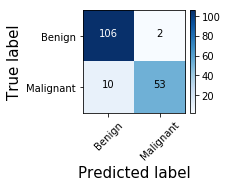

In [24]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### K-Fold Cross Validation

In [25]:
print(cross_val_score(clf, standardized_X_test[features], y_test, cv=4))

[ 0.95  0.91  0.91  0.88]


##### Visualisation

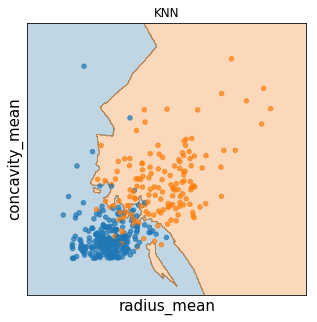

In [26]:
plt.figure(figsize=(5,5))
ax = plt.gca()
X0, X1 = X[:, 0], X[:, 1]
plot_classifier(clf, ax, X0, X1, y, title='KNN', xlabel=features[0], ylabel=features[1])

#### Experiment with 2 attributes and automated parameter selection

In [27]:
params = {
    "n_neighbors": np.arange(1,5), 
    "metric": [
        "euclidean",
        "cityblock"
    ]
}
grid = GridSearchCV(estimator=clf, param_grid=params, cv=4)
grid.fit(X, y)
print('Best score on training data: ', grid.best_score_)
print('Best parameters:')
print('\tK-neighbours:\t', grid.best_estimator_.n_neighbors)
print('\tDistance metric:', grid.best_estimator_.metric)

Best score on training data:  0.904522613065
Best parameters:
	K-neighbours:	 3
	Distance metric: cityblock


##### Cross Validation

In [28]:
print(cross_val_score(grid.best_estimator_, standardized_X_test[features], y_test, cv=4))

[ 0.98  0.93  0.88  0.9 ]


##### Confusion Matrix

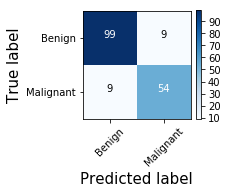

In [29]:
y_pred = grid.best_estimator_.predict(standardized_X_test[features].values)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Visualisation

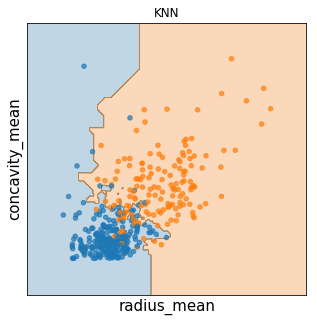

In [30]:
plt.figure(figsize=(5,5))
ax = plt.gca()
X0, X1 = X[:, 0], X[:, 1]
plot_classifier(grid.best_estimator_, ax, X0, X1, y, title='KNN', xlabel=features[0], ylabel=features[1])

Despite the difference in parameters, the cross validation result was almost identical

#### KNN with all attributes and automated parameter selection

In [31]:
X = standardized_X_train.values
y = y_train.values

In [32]:
params = {
    "n_neighbors": np.arange(1,5), 
    "metric": [
        "euclidean",
        "cityblock"
    ]
}
grid = GridSearchCV(estimator=clf, param_grid=params, cv=4)
grid.fit(X, y)
print('Best score on training data: ', grid.best_score_)
print('Best parameters:')
print('\tK-neighbours:\t', grid.best_estimator_.n_neighbors)
print('\tDistance metric:', grid.best_estimator_.metric)

Best score on training data:  0.924623115578
Best parameters:
	K-neighbours:	 4
	Distance metric: euclidean


##### Cross Validation

In [33]:
print(cross_val_score(grid.best_estimator_, standardized_X_test, y_test, cv=4))

[ 0.95  0.95  0.91  0.9 ]


##### Confusion Matrix

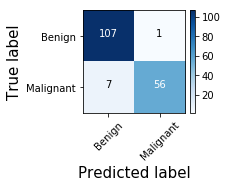

In [34]:
y_pred = grid.best_estimator_.predict(standardized_X_test.values)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Conclusion
The inclusion of all attributes only improved results slightly which indicates that the chosen attributes were good.

Both the number of false positives and false negatives decreased.


<a id="naive"></a>
### 5.2 Naive Bayes

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. It is not a single algorithm but a family of algorithms that all share a common principle, that every feature being classified is unrelated of the value of any other feature.

Advantages:
* Easy to implement
* Requires a small amount of training data to estimate the parameters

Disadvantages:
* Loss of accuracy due to assumption of class conditional independence
* Dependencies usually exist between variables and these cannot be modelled by Naive Bayes

We imported the 'GaussianNB' module from the sklearn.naive_bayes library in order to apply this technique:

In [35]:
from sklearn.naive_bayes import GaussianNB

#### Experiment with 2 attributes

In [36]:
X = standardized_X_train[features].values
y = y_train.values

##### Classification

In [37]:
clf = GaussianNB()
clf.fit(X, y)

GaussianNB(priors=None)

##### Prediction

In [38]:
y_pred = clf.predict(standardized_X_test[features].values)

##### Accuracy Score

In [39]:
accuracy_score(y_test, y_pred)

0.93567251461988299

##### Classification Report

In [40]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       108
          1       0.96      0.86      0.91        63

avg / total       0.94      0.94      0.93       171



##### Confusion Matrix

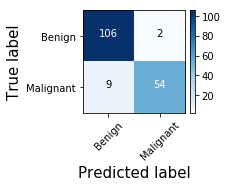

In [41]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Cross Validation

In [42]:
print(cross_val_score(clf, standardized_X_test[features], y_test, cv=4))

[ 0.95  0.95  0.91  0.93]


##### Visualisation

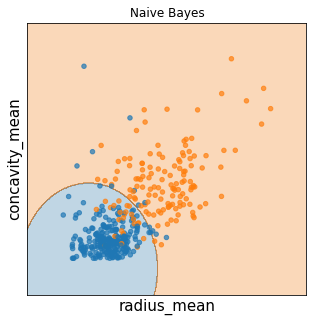

In [43]:
plt.figure(figsize=(5,5))
ax = plt.gca()
X0, X1 = X[:, 0], X[:, 1]
plot_classifier(clf, ax, X0, X1, y, title='Naive Bayes', xlabel=features[0], ylabel=features[1])

#### Naive Bayes all attributes

In [44]:
X = standardized_X_train.values
y = y_train.values

##### Classification

In [45]:
clf = GaussianNB()
clf.fit(X, y)

GaussianNB(priors=None)

##### Prediction

In [46]:
y_pred = clf.predict(standardized_X_test.values)

##### Accuracy Score

In [47]:
accuracy_score(y_test, y_pred)

0.92982456140350878

##### Classification Report

In [48]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95       108
          1       0.93      0.87      0.90        63

avg / total       0.93      0.93      0.93       171



##### Confusion Matrix

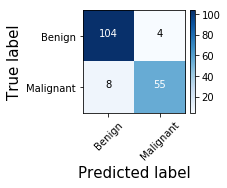

In [49]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Cross Validation

In [50]:
print(cross_val_score(clf, standardized_X_test[features], y_test, cv=4))

[ 0.95  0.95  0.91  0.93]


##### Conclusion

There is little difference with the use of all attributes with the Naive Bayes algorithm. However, the number of false negatives decreased by 1 when compared to using two features, which is a good outcome.

<a id="logreg"></a>
### 5.3 Logistic Regression

Logistic regression is a type of classification algorithm involving a linear discriminant. It is used in statistics to estimate the probability of an event occurring having been given some previous data. Logistic regression only works on binary data, and in our case, outputs the probability of a cell nucleus being malignant or benign based on a feature as input.

Advantages:
* Very flexible - independent variables do not have to be normally distibuted, or have equal variance in each group.
* It does not assume a linear relationship between independent variables and dependent variables

Disadvantages:
* Requires large sample size to achieve stable results

We used the 'LogisticRegression' module from the sklearn.linear_model library for this technique:

In [51]:
from sklearn.linear_model import LogisticRegression

##### Experiment with 2 attributes and manual parameter selection

In [52]:
X = standardized_X_train[features].values
y = y_train.values

##### Classification

In [53]:
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Prediction

In [54]:
y_pred = clf.predict(standardized_X_test[features].values)

##### Accuracy Score

In [55]:
accuracy_score(y_test, y_pred)

0.93567251461988299

##### Classification Report

In [56]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95       108
          1       0.93      0.89      0.91        63

avg / total       0.94      0.94      0.94       171



##### Confusion Matrix

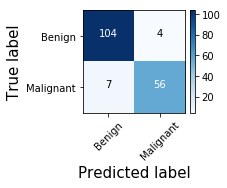

In [57]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Cross Validation

In [58]:
print(cross_val_score(clf, standardized_X_test[features], y_test, cv=4))

[ 0.95  0.95  0.91  0.88]


##### Visualisation

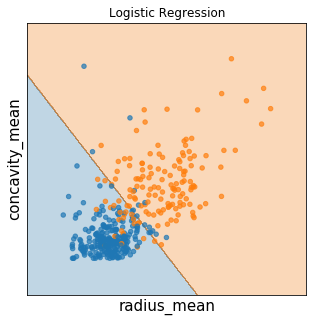

In [59]:
plt.figure(figsize=(5,5))
ax = plt.gca()
X0, X1 = X[:, 0], X[:, 1]
plot_classifier(clf, ax, X0, X1, y, title='Logistic Regression', xlabel=features[0], ylabel=features[1])

plt.show()

##### Experiment with 2 attributes and automated parameter selection

In [60]:
params = {
    "C": [0.001,0.01,0.1,1,10,100]
}
grid = GridSearchCV(estimator=clf, param_grid=params, cv=4)
grid.fit(X, y)
print('Best score on training data: ', grid.best_score_)
print('Best parameters:')
print('\tC:\t', grid.best_estimator_.C)

Best score on training data:  0.909547738693
Best parameters:
	C:	 0.001


##### Cross Validation

In [61]:
print(cross_val_score(grid.best_estimator_, standardized_X_test[features], y_test, cv=4))

[ 0.95  0.95  0.93  0.93]


##### Confusion Matrix

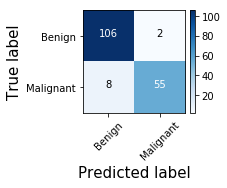

In [62]:
y_pred = grid.best_estimator_.predict(standardized_X_test[features].values)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

Using automated paratmeter selection, the number of false negatives increased by 1. False positives decreased by 2.

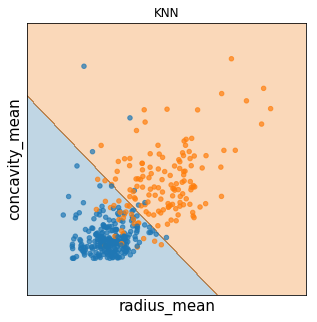

In [63]:
plt.figure(figsize=(5,5))
ax = plt.gca()
X0, X1 = X[:, 0], X[:, 1]
plot_classifier(grid.best_estimator_, ax, X0, X1, y, title='KNN', xlabel=features[0], ylabel=features[1])

plt.show()

#### Logistic regression with all attributes and automated parameter selection

In [64]:
X = standardized_X_train.values
y = y_train.values

In [65]:
params = {
    "C": [0.001,0.01,0.1,1,10,100]
}
grid = GridSearchCV(estimator=clf, param_grid=params, cv=4)
grid.fit(X, y)
print('Best score on training data: ', grid.best_score_)
print('Best parameters:')
print('\tC:\t', grid.best_estimator_.C)

Best score on training data:  0.942211055276
Best parameters:
	C:	 1


##### Cross Validation

In [66]:
print(cross_val_score(grid.best_estimator_, standardized_X_test, y_test, cv=4))

[ 0.95  0.95  0.93  0.93]


##### Confusion Matrix

In [67]:
y_pred = grid.best_estimator_.predict(standardized_X_test.values)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Conclusion

Using all attributes and automated parameter selection was the best application of logistic regression, with a best score on training data of 94%. This resulted in 6 false negatives and 4 false positives, outperforming both experiments that used 2 features only.

<a id="svm"></a>
### 5.4 Support Vector Machines
Supervised learning technique.

Assumes that the data it works with is in a standard range, usually either 0 to 1, or -1 to 1 (roughly). So the normalization of feature vectors prior to feeding them to the SVM is very important.

Variables:
First are C (the slack variable cost) and γ (the width of the Gaussian if using an RBF kernel) values. Generally these are searched in exponential factors: for C, something like 0.1, 1, 10, 100, 1000; for γ, something like 0.1, 0.01, 0.001, 0.0001, 0.00001). If possible, you should try all combinations of C and γ to find the ones that give you the best accuracy (using cross-validation)


Advantages:
* Can include expert knowledge about the problem via engineering the kernel
* Deliver a unique solution, since the optimality problem is convex

Disadvantages:
* Requires appropriate choice of kernel function

In [68]:
from sklearn import svm

#### Experiment with 2 attributes and manual parameter selection with various kernels

In [69]:
X = standardized_X_train[['radius_mean', 'concavity_mean']].values.reshape(-1,2)
y = y_train.values

# create instances of SVM and fit data
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel='sigmoid', gamma=0.1, C=C),
          svm.SVC(kernel='rbf', gamma=0.3, C=C),
          svm.SVC(kernel='poly', gamma=0.5, degree=3, C=C))

fitted_models = (clf.fit(X, y) for clf in models)

# Set-up grid for plotting.
fig, sub = plt.subplots(1, 4, figsize=(22,5))

X0, X1 = X[:, 0], X[:, 1]

for clf, ax in zip(fitted_models, sub.flatten()):
    plot_classifier(clf, ax, X0, X1, y, '{} kernel'.format(clf.kernel), xlabel='radius_mean', ylabel='concavity_mean')
    y_pred = clf.predict(standardized_X_test[features].values)
    best_score = accuracy_score(y_test, y_pred)
    ax.text(0.95, 0.05, "{:.1%}".format(best_score), size=15, ha="right", 
         transform=ax.transAxes)

plt.show()

#### Experiment with 2 attributes and automated parameter selection with various kernels

In [70]:
params = [
    {'kernel': ['linear'], 'C': [0.001,0.01,0.1,1,10], 'gamma': [0.0001, 0.001, 0.1, 0.3, 0.5, 0.7, 1]},
    {'kernel': ['sigmoid'], 'C': [0.001,0.01,0.1,1,10], 'gamma': [0.0001, 0.001, 0.1, 0.3, 0.5, 0.7, 1]},
    {'kernel': ['rbf'], 'C': [0.001,0.01,0.1,1,10], 'gamma': [0.0001, 0.001, 0.1, 0.3, 0.5, 0.7, 1]},
    {'kernel': ['poly'], 'C': [0.001,0.01,0.1,1,10,20,50], 'gamma': [0.0001, 0.001, 0.1, 0.3, 0.5, 0.7, 1], 'degree': [2, 3, 4]}
]

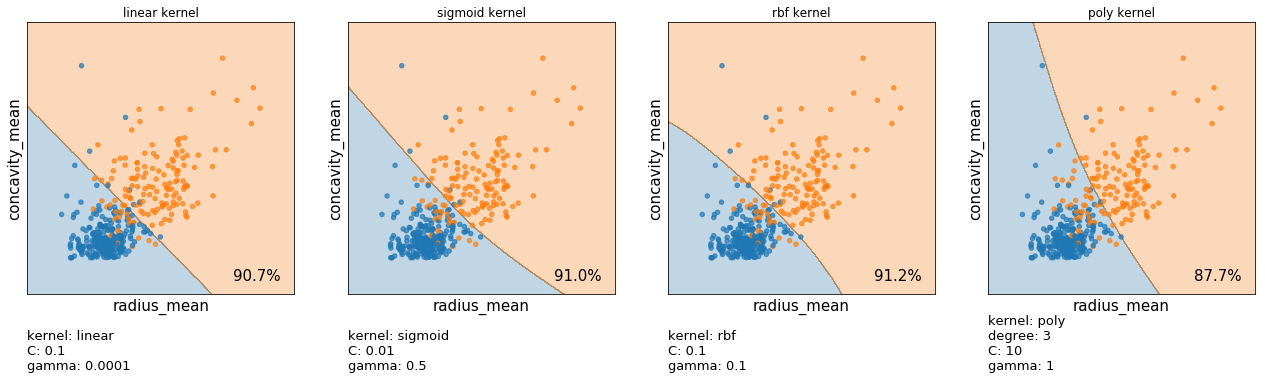

In [71]:
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 4, figsize=(22,5))

X0, X1 = X[:, 0], X[:, 1]

for clf, param, ax in zip(models, params, sub.flatten()):
    grid = GridSearchCV(estimator=clf, param_grid=param, cv=4)
    grid.fit(X, y)
    best_param = {k: grid.best_estimator_.__getattribute__(k) for k in param.keys()}
    plot_classifier(grid.best_estimator_, ax, X0, X1, y, '{} kernel'.format(clf.kernel), xlabel='radius_mean', ylabel='concavity_mean')
    ax.text(0.95, 0.05, "{:.1%}".format(grid.best_score_), size=15, ha="right", 
         transform=ax.transAxes)
    ax.text(0, -0.275, '\n'.join('{}: {}'.format(k, v) for k, v in best_param.items()), size=13, ha="left", 
         transform=ax.transAxes)

plt.show()

#### SVM with all attributes and automated parameter selection

In [72]:
X = standardized_X_train.values
y = y_train.values

In [73]:
clf = svm.SVC()

estimators = []

for param in params:
    grid = GridSearchCV(estimator=clf, param_grid=param, cv=4)
    grid.fit(X, y)
    estimators.append(grid.best_estimator_)
    best_param = {k: grid.best_estimator_.__getattribute__(k) for k in param.keys()}
    print('Kernel: ', grid.best_estimator_.kernel)
    print('Best score on training data: {:.1%}'.format(grid.best_score_))
    print('Best parameters:')
    print('\n'.join('\t{}: {}'.format(k, v) for k, v in best_param.items()))

Kernel:  linear
Best score on training data: 93.2%
Best parameters:
	kernel: linear
	C: 0.1
	gamma: 0.0001
Kernel:  sigmoid
Best score on training data: 93.2%
Best parameters:
	kernel: sigmoid
	C: 0.01
	gamma: 0.5
Kernel:  rbf
Best score on training data: 93.7%
Best parameters:
	kernel: rbf
	C: 1
	gamma: 0.1
Kernel:  poly
Best score on training data: 93.2%
Best parameters:
	kernel: poly
	degree: 3
	C: 1
	gamma: 0.5


##### Cross Validation

In [74]:
for estimator in estimators:
    print(estimator.kernel, ':')
    scores = cross_val_score(estimator, standardized_X_test, y_test, cv=10)
    mean = np.mean(scores)
    std = np.std(scores)
    print('\t{:.1%} ± {:.1%} @ 95% confidence'.format(mean, std))

linear :
	94.7% ± 4.9% @ 95% confidence
sigmoid :
	88.1% ± 6.8% @ 95% confidence
rbf :
	93.5% ± 6.8% @ 95% confidence
poly :
	94.1% ± 4.6% @ 95% confidence


##### Confusion Matrix

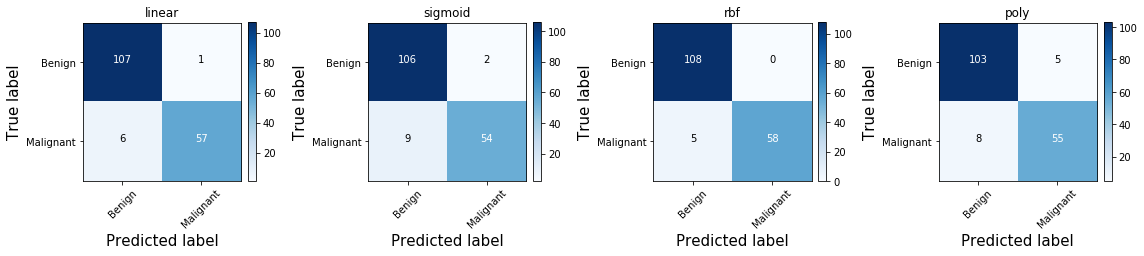

In [75]:
fig, sub = plt.subplots(1, 4, figsize=(16,4))

for estimator, ax in zip(estimators, sub.flatten()):
    y_pred = estimator.predict(standardized_X_test.values)
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), title=estimator.kernel, ax=ax)

##### Conclusion

The rbf kernel function produced the very good results using the SVM algorithm, with a best score on training data of 93.7%. The rbf function's confusion matrix shows 5 false-negatives and zero false-positives. The worst performing functions were sigmoid and poly, with 9 and 8 false-negatives, respectively.

<a id="trees"></a>
### 5.5 Decision Trees

In [76]:
X = standardized_X_train
y = y_train

In [77]:
from sklearn import tree
import graphviz

#### Classification - Manual Parameter Selection

In [78]:
clf = tree.DecisionTreeClassifier('entropy', max_depth=5, random_state=42)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

##### Visualisation

In [79]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns)  
graph = graphviz.Source(dot_data)  
graph 

In [80]:
y_pred = clf.predict(standardized_X_test.values)

##### Accuracy Score

In [81]:
accuracy_score(y_test, y_pred)

0.94152046783625731

##### Classification Report

In [82]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.94      0.95       108
          1       0.91      0.94      0.92        63

avg / total       0.94      0.94      0.94       171



##### Confusion Matrix

In [83]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Cross Validation

In [84]:
print(cross_val_score(clf, standardized_X_test[features], y_test, cv=4))

[ 0.95  0.93  0.88  0.88]


Manual parameter selection actually worked quite well with only 4 false negatives

#### Classification - Automated Parameter Selection

In [85]:
params = {
    "max_depth": [3, 4, 5, 6, 7],
    "random_state": [42]
}
grid = GridSearchCV(estimator=clf, param_grid=params, cv=3)
grid.fit(X, y)
print('Best score on training data: ', grid.best_score_)
print('Best parameters:')
print('\tmax_depth:\t', grid.best_estimator_.max_depth)

Best score on training data:  0.914572864322
Best parameters:
	max_depth:	 4


##### Visualisation

In [86]:
dot_data = tree.export_graphviz(grid.best_estimator_, out_file=None, feature_names=X.columns)  
graph = graphviz.Source(dot_data)  
graph

##### Cross Validation

In [87]:
print(cross_val_score(grid.best_estimator_, standardized_X_test, y_test, cv=4))

[ 0.98  0.95  0.91  0.95]


##### Confusion Matrix

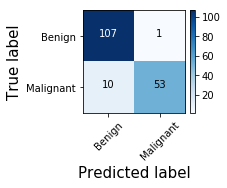

In [88]:
y_pred = grid.best_estimator_.predict(standardized_X_test.values)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), title='')

##### Conclusion

Using decision trees resulted in 10 false-positives, which is not a good outcome in comparison to earlier techniques.

Interestingly, the automated approach performed much worse. This may have been due to the fact that in order to find the best parameters, the algorithm had to split the training data for cross validation.

<a id="desc"></a>
## 6. Descriptive Analytics

Descriptive analysis describes or summarises raw data in an understandable format that humans can understand, to either inform or prepare data for further analysis. This is analytics that describes the past. Descriptive analytics are useful because they allow data scientists to learn from past behaviors, and understand how they might influence future outcomes.

<a id="kmeans"></a>
### 6.1 K-Means

K-means is a method of vector quantization that is popularily used in cluster analysis in data mining. It partitions n observations into k number of clusters where each observation belongs to the cluster with the nearest mean.

Advantages:
* Ease of implementation
* Easy to interpret clustering results

Disadvantages:
* Sometimes difficult to predict K value, the optimal number of clusters
* Different initial partitions can result in different final clusters

In [89]:
from sklearn import preprocessing

In [90]:
# Scaling the dataset
datas = pd.DataFrame(preprocessing.scale(clean_data.iloc[:,1:32]))
datas.columns = list(clean_data.iloc[:,1:32].columns)
datas['diagnosis'] = clean_data['diagnosis']
# Creating the high dimensional feature space X
data_drop = datas.drop('diagnosis',axis=1)
X = data_drop.values

TSNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [91]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=40, n_iter= 4000)
Y = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.660027
[t-SNE] Error after 1350 iterations: 0.908491


Now we visualise the differences between the true labels and what KMeans concluded. We set the random state for the algorithm to provide consistency.

In [92]:
from sklearn.cluster import KMeans
kmns = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=42, copy_x=True, n_jobs=1, algorithm='auto')
kY = kmns.fit_predict(X)

In [93]:
centroids = kmns.cluster_centers_
labels = kmns.labels_

true1 = [True if i==1 else False for i in labels.tolist()]
true0 = [True if i==0 else False for i in labels.tolist()]

true1y = [True if i==1 else False for i in datas.diagnosis]
true0y = [True if i==0 else False for i in datas.diagnosis]


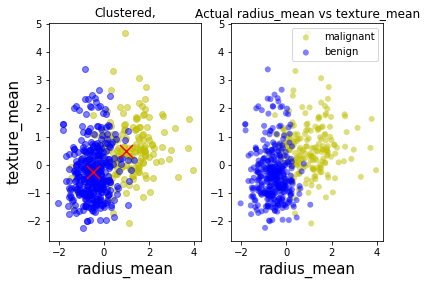

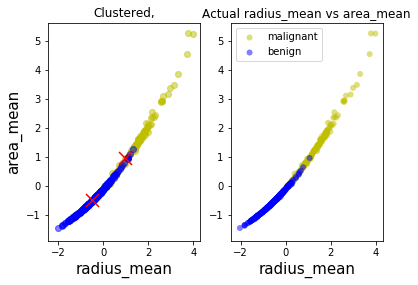

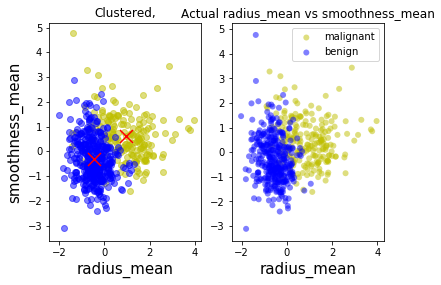

In [94]:
#Creating a 2D visualization to visualize the clusters
count = 0
for m,i in enumerate(datas.columns.tolist()):
    for n,j in enumerate(datas.columns.tolist()):
        if i!=j and count <4:
            fig = plt.figure()
            
            ax1 = fig.add_subplot(121)
            
            ax1.scatter(datas[true0][i],datas[true0][j], c="y", alpha=0.50)
            ax1.scatter(datas[true1][i],datas[true1][j], c="b", alpha=0.50)
            ax1.scatter(centroids[:, m], centroids[:, n],
                        marker='x', s=169, linewidths=3,
                        color='r', zorder=10)
            title1 = "Clustered,"
            ax1.set_title(title1)
            ax1.set_xlabel(i)
            ax1.set_ylabel(j)
            
            ax2 = fig.add_subplot(122)
            ax2.scatter(datas[true1y][i],datas[true1y][j], c="y",cmap = "jet", edgecolor = "None", alpha=0.50)
            ax2.scatter(datas[true0y][i],datas[true0y][j], c="b",cmap = "jet", edgecolor = "None", alpha=0.50)
            title2 = "Actual "+ i + " vs " + j
            ax2.set_title(title2)
            ax2.set_xlabel(i)

            plt.legend(['malignant', 'benign'])
            plt.show()
            count += 1

The red crosses in the clustered graphs on the left mark the centroids.

#### Conclusion

The K-Means Clusters appear to be quite similiar to the actual data.

<a id="spect"></a>
### 6.2 Spectral Clustering 

Spectral clustering makes use of the spectrum of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. 
In our case when calling 'fit', an affinity matrix is constructed using the Gaussian (aka RBF) kernel of the euclidean distanced d(X, X)

np.exp(-gamma * d(X,X) ** 2)

This is how adjusting gamma can be used to tweak the clustering results.

Advantages:
* Useful in hard non-convex clustering problems

Disadvantages:
* Like K-Means, sometimes difficult to determine optimal number of clusters

In [95]:
from sklearn.cluster import SpectralClustering

# Edit gamma to optimize the clustering results
kmns = SpectralClustering(n_clusters=2,  gamma=0.5, affinity='rbf', eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=1, random_state=42)
kY = kmns.fit_predict(X)


In [96]:
labels = kmns.labels_

true1 = [True if i==1 else False for i in labels.tolist()]
true0 = [True if i==0 else False for i in labels.tolist()]

true1y = [True if i==1 else False for i in datas.diagnosis]
true0y = [True if i==0 else False for i in datas.diagnosis]

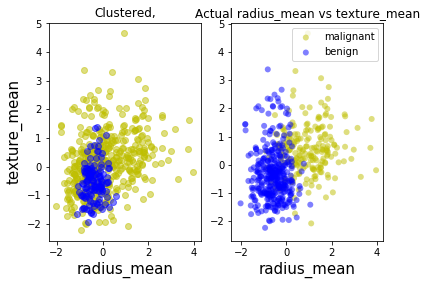

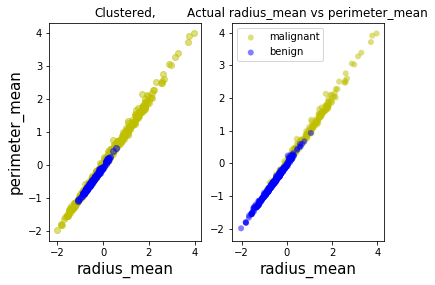

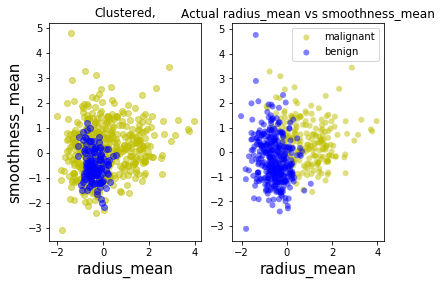

In [97]:
count = 0
for m,i in enumerate(datas.columns.tolist()):
    for n,j in enumerate(datas.columns.tolist()):
        if i!=j and count <4:
            fig = plt.figure()
            
            ax1 = fig.add_subplot(121)

            
            ax1.scatter(datas[true0][i],datas[true0][j], c="y", alpha=0.50)
            ax1.scatter(datas[true1][i],datas[true1][j], c="b", alpha=0.50)
            title1 = "Clustered,"
            ax1.set_title(title1)
            ax1.set_xlabel(i)
            ax1.set_ylabel(j)
            
            ax2 = fig.add_subplot(122)
            ax2.scatter(datas[true1y][i],datas[true1y][j], c="y",cmap = "jet", edgecolor = "None", alpha=0.50)
            ax2.scatter(datas[true0y][i],datas[true0y][j], c="b",cmap = "jet", edgecolor = "None", alpha=0.50)
            
            title2 = "Actual "+ i + " vs " + j
            ax2.set_title(title2)
            ax2.set_xlabel(i)

            plt.legend(['malignant', 'benign'])
            plt.show()
            count += 1

#### Conclusion

The Spectral Clustering technqiue resulted in significantly different clusters when compared to the actual data. It is clear that there is a more concentrated benign cluster in all graphs, with the malignant cluster more spread out and scattered. This is in contrast to the actual data which shows a more uniform split between the two clusters.

<a id="conclusion"></a>
## 7. Conclusion

Overall, we found this breast cancer dataset very interesting to work with. We don't believe that we discovered any previously unknown information but we managed to get some meaningful information from the dataset. Through the use of automatic feature selection, the following features were found to be interesting:
* concave points_mean
* concavity_mean
* radius_mean
* perimeter_mean
* compactness_mean

We eliminated three highly correlated features, leaving 'radius_mean' and 'concavity_mean'. These two features were then used during Predictive Analytics using the following algorithms: KNN, Naive Bayes, Logistic Regression, Support Vector Machines and Decision Trees.

After the Predictive Analytics stage, we discovered that the Support Vector Machines technique produced the best results whilst using the rbf kernel function and all features as input. The rbf function resulted in a best score on training data of 93.7% accompanied with 5 false-negatives and zero false-positives. Another good performer was Logistic Regression with all features and automated parameter selection, with a best score on training data of 94%. Logistic Regression resulted in 6 false-negatives and 4 false-positives. Using Decision Trees produced the worst results of the five techniques, with the confusion matrix showing 10 false-negatives.

It is also evident that in many cases our manual parameter selection resulted in better performance than automated parameter selection. This likely occured for two reasons. Firstly, we seem to have chosen two of the best attributes and also some good parameters for the algorithms. Secondly, the automated parameter selection actually performs its own cross validation so it further splits the training data.

During Descriptive Analysis, we used the K-Means Clustering and Spectral Clustering techniques. The techniques were carried out while plotting the following features against 'radius_mean': 'texture_mean', 'perimeter_mean', 'area_mean' and 'smoothness_mean'. K-Means Clustering did not show too much clustering difference when compared to the actual data. However, the Spectral Clustering graphs showed a more concentrated benign cluster accompanied a more scattered malignant cluster. These clusters look to be harder to split when compared with the actual data graphs.

In order for data mining and machine learning techniques to be introduced and relied on in healthcare, a near 100% certainty of zero false-negatives would be required. Fow now, data science will assist health professionals and researchers but is a far way off from replacing human's diagnosis. However, it is interesting to think about the techniques that are available now and what will be available in the future for a the diagnosis of cancer and other illnesses. We found this project very interesting to work on, it was fascinating to use the data to gain insights into real life problems.
<br><br>